## Model Optimizasyonu

**Amaç:** Zenginleştirilmiş veri ve LightGBM + Optuna kullanarak en iyi arıza yakalama (Recall) skoruna ulaşmak.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os

# Ayarlar
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
# Optuna loglarını biraz sessize alalım
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Zengin Veriyi Yükle
data_path = '../data/processed/sensor_enriched.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')
    print(f"Zengin Veri Yüklendi. Boyut: {df.shape}")
else:
    raise FileNotFoundError("Önce 03_FeatureEngineering notebook'unu çalıştırmalısın.")

Zengin Veri Yüklendi. Boyut: (205783, 409)


- Baseline notebook'unda yaptığımız gibi son arızayı bulup ve kesme noktasını belirleyeceğiz.

In [17]:
# Hedef ve Özellikler
X = df.drop(columns=['y', 'machine_status'], errors='ignore')
y = df['y']

last_failure_date = y[y==1].index.max()
print(f"Son Arıza Sinyali: {last_failure_date}")

if pd.notnull(last_failure_date):
    # Son arızadan 5 gün öncesinden keselim
    split_date = last_failure_date - pd.Timedelta(days=5)
else:
    # Hiç arıza yoksa standart %20
    split_date = df.index.max() - pd.Timedelta(days=30)

print(f"Train/Test Kesme Tarihi: {split_date}")

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Test setindeki '1' (Arıza) sayısı: {y_test.sum()}")

Son Arıza Sinyali: 2018-07-25 14:00:00
Train/Test Kesme Tarihi: 2018-07-20 14:00:00
Train: (144778, 408), Test: (61005, 408)
Test setindeki '1' (Arıza) sayısı: 1441


- Optuna ile eğitim yapılacak. (Train seti üzerinden) Train'in son %20'sini validasyon gibi kullanalım.

In [27]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 200,
        # Dengesiz veri için kritik parametre: Pozitif sınıfa ne kadar ağırlık verelim?
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 80.0, 150.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),        
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),  # Daha küçük
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    
    val_split_idx = int(len(X_train) * 0.8)
    X_tr_opt = X_train.iloc[:val_split_idx]
    y_tr_opt = y_train.iloc[:val_split_idx]
    X_val_opt = X_train.iloc[val_split_idx:]
    y_val_opt = y_train.iloc[val_split_idx:]
    
    model = lgb.LGBMClassifier(**param)
    
    # Callback yerine direct fit parametreleri
    model.fit(
        X_tr_opt, y_tr_opt,
        eval_set=[(X_val_opt, y_val_opt)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    # Başarıyı Ölç (Recall bizim için en önemli metrik)
    preds = model.predict(X_val_opt)
    # F1 Score ile hem precision hem recall dengesini arayalım
    score = recall_score(y_val_opt, preds)

    return score


print("Optuna optimizasyonu başlıyor... En iyi ayarlar aranıyor.")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

print("\nEn İyi Parametreler:")
print(study.best_params)

Optuna optimizasyonu başlıyor... En iyi ayarlar aranıyor.

En İyi Parametreler:
{'scale_pos_weight': 86.42906290857908, 'learning_rate': 0.03391822236545901, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.7886358944252985, 'colsample_bytree': 0.9851219688720165}


In [28]:
# Mevcut modelle threshold ayarla
y_prob = final_model.predict_proba(X_test)[:, 1]

for threshold in [0.1, 0.15, 0.2, 0.25, 0.3]:
    y_pred = (y_prob > threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_test, y_pred))


Threshold: 0.1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005


Threshold: 0.15
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005


Threshold: 0.2
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95  

d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\w

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005



d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Final Model Eğitimi
- En iyi ayarlar alınıp büyük eğitim yapılır.

En iyi parametrelerle final model eğitiliyor...

--- FİNAL SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005



d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


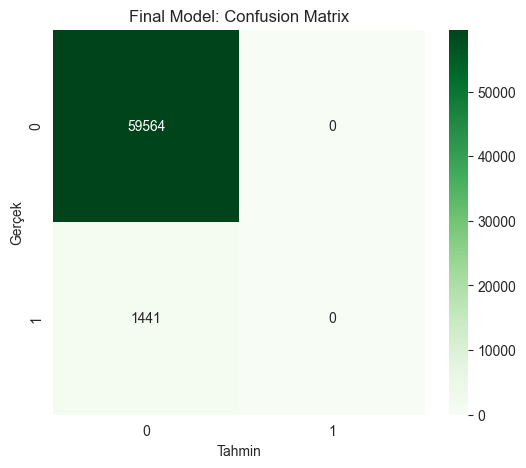

In [ ]:
print("En iyi parametrelerle final model eğitiliyor...")

best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['n_estimators'] = 500 # Finalde daha fazla ağaç kullanabiliriz

final_model = lgb.LGBMClassifier(**best_params)

final_model.fit(X_train, y_train)

y_prob = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.2).astype(int)

print("\n--- FİNAL SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Final Model: Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

- Hangi özellikler model için en değerliydi? Ham veriler mi, bizim türettiklerimiz mi?

C:\Users\Oznur\AppData\Local\Temp\ipykernel_10648\309169886.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance.head(20), palette='viridis')


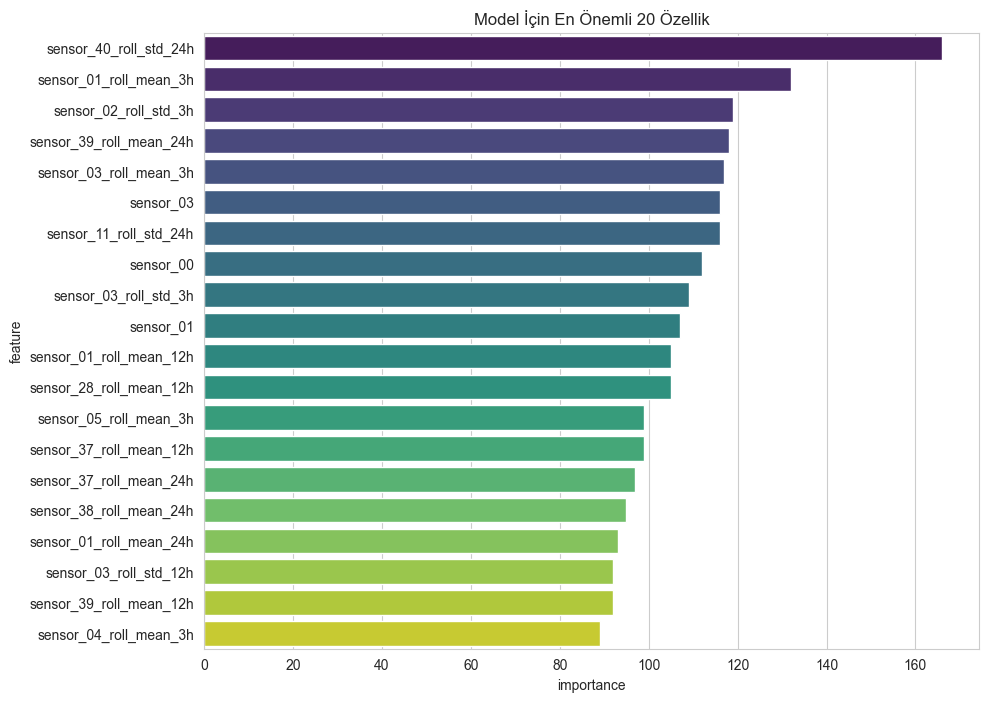

Final model kaydedildi: models/final_lgbm_model.pkl


In [6]:
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance.head(20), palette='viridis')
plt.title("Model İçin En Önemli 20 Özellik")
plt.show()

# Modeli Kaydet
joblib.dump(final_model, '../models/final_lgbm_model.pkl')
print("Final model kaydedildi: models/final_lgbm_model.pkl")

In [29]:
# ---  MODEL VE FEATURE LİSTESİNİ EŞİTLEMEK İÇİN DENEME ---
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import joblib
import os

# 1. Veriyi Yükle
print("🔄 Veri yükleniyor...")
df = pd.read_csv('../data/processed/sensor_enriched.csv', parse_dates=['timestamp'], index_col='timestamp')

# 2. 'sensor_40'ı (Sızıntı Kaynağı) Çıkar
X = df.drop(columns=['y', 'machine_status'], errors='ignore')
cols_to_drop = [c for c in X.columns if 'sensor_40' in c]
X = X.drop(columns=cols_to_drop)
y = df['y']

print(f"📊 Modelin Beklediği Özellik Sayısı: {X.shape[1]} (Bu sayı 408 olmalı)")

# 3. Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42
)

# 4. Modeli Eğit
print("🚀 Model eğitiliyor...")
model = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05, num_leaves=31,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    n_jobs=-1, verbose=-1
)
model.fit(X_train, y_train)

# 5. EŞ ZAMANLI KAYIT (Kritik Kısım)
# Modeli ve o modelin kullandığı sütun isimlerini aynı anda kaydediyoruz.
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

joblib.dump(model, os.path.join(models_dir, 'final_lgbm_model.pkl'))
joblib.dump(X_train.columns.tolist(), os.path.join(models_dir, 'model_features.pkl'))

print(f"✅ Model kaydedildi: {os.path.join(models_dir, 'final_lgbm_model.pkl')}")
print(f"✅ Özellik listesi kaydedildi: {os.path.join(models_dir, 'model_features.pkl')}")
print(f"📏 Kaydedilen Özellik Listesi Uzunluğu: {len(X_train.columns)}")

🔄 Veri yükleniyor...
📊 Modelin Beklediği Özellik Sayısı: 400 (Bu sayı 408 olmalı)
🚀 Model eğitiliyor...
✅ Model kaydedildi: ../models\final_lgbm_model.pkl
✅ Özellik listesi kaydedildi: ../models\model_features.pkl
📏 Kaydedilen Özellik Listesi Uzunluğu: 400
